In [28]:
import os
import pandas as pd
import numpy as np
from cgcnn2.util import cgcnn_pred
import argparse

In [29]:
MODEL = "R2_0.9384/best_model_0.9384.ckpt"          # 模型路径
CIF_DIR = "data_core/cif/CSD-modified/cifs/CR/FSR"          # CoRE 的 cif 目录
OUT_CSV = "data_core/core_predictions.csv"  

In [30]:
# 路径 & 参数
pred_csv = "data_core/core_predictions.csv"      # 你的预测结果
out_csv  = "data_core/recommended_top500.csv"    # 输出的新数据集
k = 500                                          # Top-K

# 1) 读入 + 基础清洗
df = pd.read_csv(pred_csv)
if "id" not in df.columns or "prediction" not in df.columns:
    raise ValueError("CSV 必须包含列: id 和 prediction")

# 可选：把带 .cif 的 id 规范为不带后缀（便于下游使用）
df["id"] = df["id"].astype(str).str.replace(r"\.cif$", "", regex=True)

# 预测值转数值并去掉缺失
df["prediction"] = pd.to_numeric(df["prediction"], errors="coerce")
df = df.dropna(subset=["prediction"])

# 2) 排序（默认越大越好）+ 去重（同一 id 保留最高预测值）
df = df.sort_values("prediction", ascending=False)
df = df.drop_duplicates(subset=["id"], keep="first")

# 3) 取 Top-K 并加 rank
topk = df.head(k).copy()
topk.insert(0, "rank", range(1, len(topk) + 1))

# 4) 保存并预览
topk.to_csv(out_csv, index=False)
print(f"✅ 已保存 Top-{len(topk)} 到: {out_csv}")
topk.head(10)

✅ 已保存 Top-500 到: data_core/recommended_top500.csv


,rank,id,prediction
3086,1,2019[Cu][nan]2[FSR]4,118.395859
422,2,2007[Cu][dia]3[FSR]1,114.262589
738,3,2009[La][pcu]3[FSR]1,113.816956
557,4,2008[Cu][dia]3[FSR]2,105.825607
3301,5,2020[GeCu][sql]2[FSR]3,102.862885
146,6,2004[Ag][pts]3[FSR]1,97.572105
3300,7,2020[GeCu][sql]2[FSR]2,97.328857
846,8,2010[Co][tbo]3[FSR]1,94.155960
148,9,2004[Ag][pts]3[FSR]3,91.826561
147,10,2004[Ag][pts]3[FSR]2,88.613785


,rank,id,prediction
0,1,2019[Cu][nan]2[FSR]4,118.395859
1,2,2007[Cu][dia]3[FSR]1,114.262589
2,3,2009[La][pcu]3[FSR]1,113.816956
3,4,2008[Cu][dia]3[FSR]2,105.825607
4,5,2020[GeCu][sql]2[FSR]3,102.862885
5,6,2004[Ag][pts]3[FSR]1,97.572105
6,7,2020[GeCu][sql]2[FSR]2,97.328857
7,8,2010[Co][tbo]3[FSR]1,94.155960
8,9,2004[Ag][pts]3[FSR]3,91.826561
9,10,2004[Ag][pts]3[FSR]2,88.613785


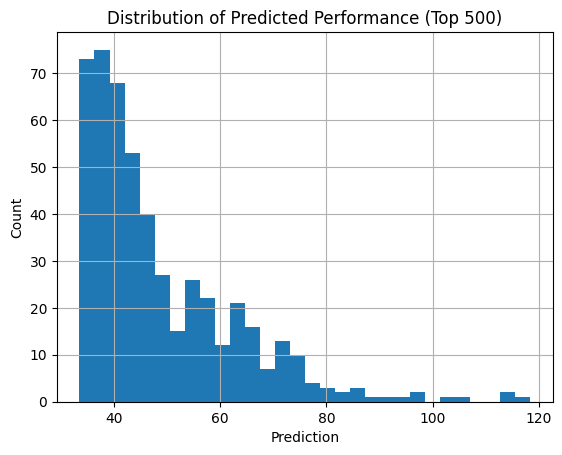

saved to: data_core/recommended_top500_ranked.csv


In [31]:
import matplotlib.pyplot as plt
from IPython.display import display  # 用于在 notebook 里展示表格

# 1) 读数据
csv_path = "/mnt/data/recommended_top500.csv"  # 或 "data_core/recommended_top500.csv"
if not os.path.exists(csv_path):
    csv_path = "data_core/recommended_top500.csv"

df = pd.read_csv(csv_path)

# 2) 基础清洗
assert {"id","prediction"}.issubset(df.columns), "CSV 必须包含: id, prediction"
df["id"] = df["id"].astype(str).str.replace(r"\.cif$", "", regex=True)
df["prediction"] = pd.to_numeric(df["prediction"], errors="coerce")
df = df.dropna(subset=["prediction"]).copy()

# 3) 排序、去重、加 rank
df = df.sort_values("prediction", ascending=False).drop_duplicates(subset=["id"]).reset_index(drop=True)
df["rank"] = np.arange(1, len(df) + 1)

# 4) 预览 & 直方图
display(df.loc[:29, ["rank","id","prediction"]])   # Top 30 预览

plt.figure()
df["prediction"].hist(bins=30)
plt.title("Distribution of Predicted Performance (Top 500)")
plt.xlabel("Prediction"); plt.ylabel("Count")
plt.show()

# 5) 保存清洗后的文件
out_clean = "data_core/recommended_top500_ranked.csv"
os.makedirs(os.path.dirname(out_clean), exist_ok=True)
df.to_csv(out_clean, index=False)
print(f"saved to: {out_clean}")

基础特征完成，缺失 0 条（见 CSV）


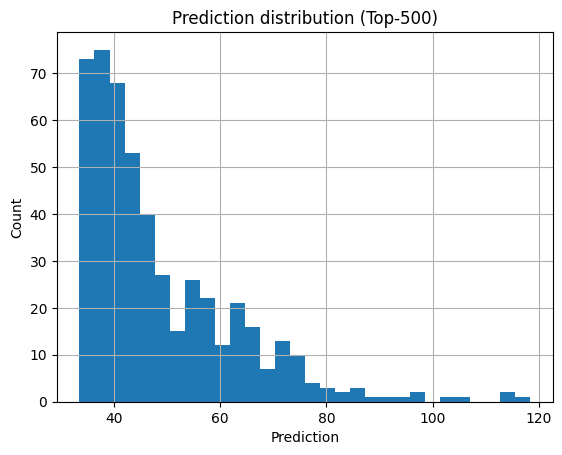

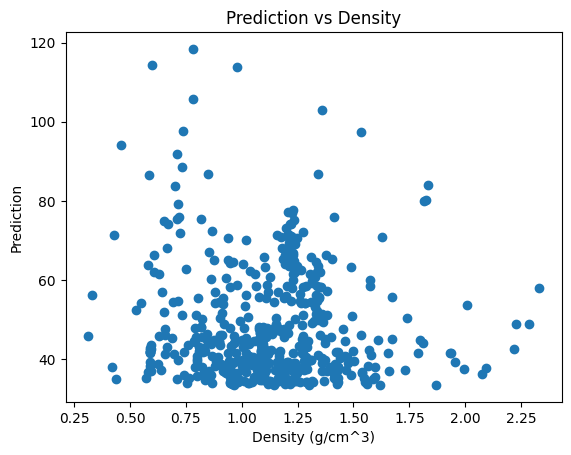

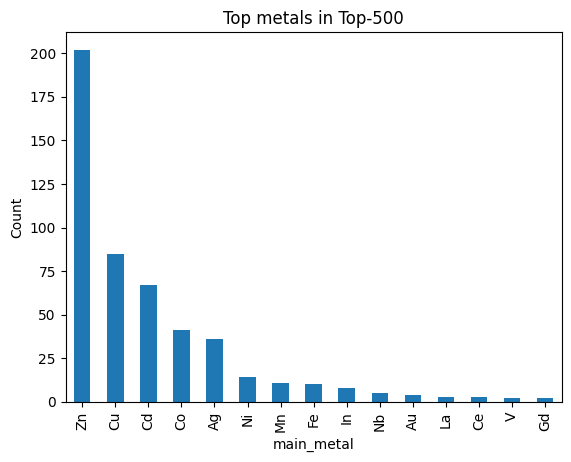

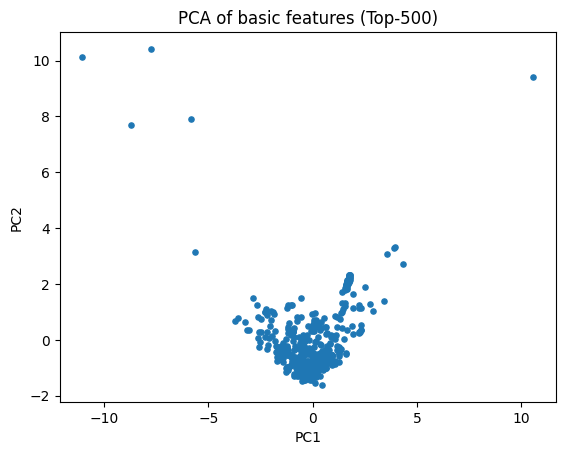

Diverse shortlist saved: analysis_top500\diverse_top_12x5.csv


In [32]:
import re, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pymatgen.core import Structure, Element

# ====== 路径 ======
PRED_CSV = "data_core/recommended_top500.csv"     # 含 id,prediction,rank(可有可无)
CIF_DIR  = "data_core/cif/CSD-modified/cifs/CR/FSR"  # 500个CIF所在目录
OUT_DIR  = "analysis_top500"
os.makedirs(OUT_DIR, exist_ok=True)

# ====== 读预测表 ======
df = pd.read_csv(PRED_CSV)
assert {"id","prediction"}.issubset(df.columns), "CSV 必须包含 id,prediction"
df["id"] = df["id"].astype(str).str.replace(r"\.cif$","",regex=True)
df["prediction"] = pd.to_numeric(df["prediction"], errors="coerce")
df = df.dropna(subset=["prediction"]).drop_duplicates("id").sort_values("prediction", ascending=False).reset_index(drop=True)
df["rank"] = np.arange(1, len(df)+1)

# ====== 工具函数：把 id 映射到 CIF 路径 ======
def find_cif(cif_dir, id_):
    cand = [os.path.join(cif_dir, f"{id_}.cif"), os.path.join(cif_dir, id_)]
    for p in cand:
        if os.path.exists(p):
            return p
    return None

def basic_feats(cif_path):
    s = Structure.from_file(cif_path)
    vol = s.volume
    natoms = len(s)
    density = s.density  # g/cm^3 (crystal density)
    comp = s.composition.fractional_composition.as_dict()  # element fraction
    # 金属/非金属比例 + 主金属
    metal_frac = 0.0
    main_metal, main_metal_frac = None, 0.0
    for el, frac in comp.items():
        if Element(el).is_metal:
            metal_frac += frac
            if frac > main_metal_frac:
                main_metal, main_metal_frac = el, frac
    # 粗略“有机/无机”指标（C,N,O,H,F,Cl,Br,I 常见）
    organics = sum(frac for el, frac in comp.items() if el in {"C","H","N","O","F","Cl","Br","I"})
    return {
        "volume": vol,
        "n_atoms": natoms,
        "density": density,
        "metal_frac": metal_frac,
        "organic_frac": organics,
        "main_metal": main_metal or "None"
    }

# 批量提取
rows = []
miss = []
for i, r in df.iterrows():
    cifp = find_cif(CIF_DIR, r["id"])
    if cifp is None:
        miss.append(r["id"])
        continue
    try:
        feat = basic_feats(cifp)
        feat["id"] = r["id"]
        rows.append(feat)
    except Exception as e:
        miss.append(r["id"])

feat_df = pd.DataFrame(rows)
merged = df.merge(feat_df, on="id", how="left")
merged.to_csv(os.path.join(OUT_DIR, "top500_basic_features.csv"), index=False)
print(f"基础特征完成，缺失 {len(miss)} 条（见 CSV）")

# ====== 快速可视化 ======
plt.figure(); merged["prediction"].hist(bins=30)
plt.title("Prediction distribution (Top-500)"); plt.xlabel("Prediction"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.scatter(merged["density"], merged["prediction"])
plt.xlabel("Density (g/cm^3)"); plt.ylabel("Prediction"); plt.title("Prediction vs Density"); plt.show()

plt.figure(); merged["main_metal"].value_counts().head(15).plot(kind="bar")
plt.title("Top metals in Top-500"); plt.ylabel("Count"); plt.show()

# ====== PCA + KMeans 做“多样性去重” ======
num_cols = ["density","volume","n_atoms","metal_frac","organic_frac","prediction"]
X = merged[num_cols].fillna(merged[num_cols].median())
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42).fit_transform(Xz)
merged["pc1"] = pca[:,0]; merged["pc2"] = pca[:,1]

k = 12
km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(Xz)
merged["cluster"] = km.labels_

# 每簇取前 m 个（按 prediction 降序），得到“多样性代表队”
m = 5
diverse = (merged.sort_values("prediction", ascending=False)
                 .groupby("cluster").head(m)
                 .sort_values(["cluster","prediction"], ascending=[True,False]))
diverse.to_csv(os.path.join(OUT_DIR, f"diverse_top_{k}x{m}.csv"), index=False)

# 可视化 PCA
plt.figure()
plt.scatter(merged["pc1"], merged["pc2"], s=14)
plt.title("PCA of basic features (Top-500)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

print("Diverse shortlist saved:", os.path.join(OUT_DIR, f"diverse_top_{k}x{m}.csv"))

In [33]:
import os, shutil, pandas as pd

# ===== 路径参数（改这里） =====
PRED_CSV = "data_core/recommended_top500.csv"       # 含至少: id, prediction（已排序更好）
CIF_DIR  = "data_core/cif/CSD-modified/cifs/CR/FSR" # ASR 全库目录（源）
OUT_DIR  = "data_core/CIF_DIR_top500"               # 目标数据集根目录（将新建）
TOPK     = 500                                      # 取前K个

# ===== 读入并取前K个 ID =====
df = pd.read_csv(PRED_CSV)
if "id" not in df.columns:
    raise ValueError("CSV 必须包含列: id")
ids = (
    df["id"]
    .astype(str)
    .str.replace(r"\.cif$", "", regex=True)   # 统一去掉后缀
    .drop_duplicates()
    .head(TOPK)
    .tolist()
)

# ===== 创建输出目录 =====
cif_out = os.path.join(OUT_DIR, "cif")
os.makedirs(cif_out, exist_ok=True)

# ===== 小工具：在 CIF_DIR 中查找文件（支持 id.cif / id 两种命名） =====
def find_cif(cif_dir: str, cif_id: str):
    cand = [
        os.path.join(cif_dir, f"{cif_id}.cif"),
        os.path.join(cif_dir, cif_id),
    ]
    for p in cand:
        if os.path.exists(p):
            return p
    return None

# ===== 复制并记录 =====
manifest_rows, missing = [], []
for i, cif_id in enumerate(ids, 1):
    src = find_cif(CIF_DIR, cif_id)
    if src is None:
        missing.append(cif_id)
        continue
    dst_name = f"{cif_id}.cif"
    dst = os.path.join(cif_out, dst_name)
    shutil.copy2(src, dst)
    manifest_rows.append({"rank": i, "id": cif_id, "cif_file": f"cif/{dst_name}"})

# ===== 写出 manifest / README / ids 列表 =====
pd.DataFrame(manifest_rows).to_csv(os.path.join(OUT_DIR, "manifest.csv"), index=False)

with open(os.path.join(OUT_DIR, "ids_top500.txt"), "w", encoding="utf-8") as f:
    for _id in ids:
        f.write(f"{_id}\n")

with open(os.path.join(OUT_DIR, "README.txt"), "w", encoding="utf-8") as f:
    f.write(
        "CIF_DIR_top500 dataset\n"
        f"- Source predictions : {os.path.abspath(PRED_CSV)}\n"
        f"- CIF source dir     : {os.path.abspath(CIF_DIR)}\n"
        f"- Output dir         : {os.path.abspath(OUT_DIR)}\n"
        f"- K                  : {len(ids)} requested\n"
        f"- Copied             : {len(manifest_rows)}\n"
    )
    if missing:
        f.write(f"\nMissing ({len(missing)}):\n")
        for m in missing[:50]:
            f.write(f"  - {m}\n")
        if len(missing) > 50:
            f.write("  ... (truncated)\n")

print(f"完成：复制 {len(manifest_rows)}/{len(ids)} 个 CIF → {cif_out}")
if missing:
    print(f"有 {len(missing)} 个 ID 未在源目录找到，对应列表已写入 README.txt")

完成：复制 500/500 个 CIF → data_core/CIF_DIR_top500\cif


In [34]:
import torch
from torch.utils.data import DataLoader
from cgcnn2.util import cgcnn_pred
from cgcnn2.data import CIFData, collate_pool, CIFData_NoTarget
from cgcnn2.model import CrystalGraphConvNet
from cgcnn2.util import cgcnn_descriptor

CIF_DIR_TOP500 = "data_core/CIF_DIR_top500/cif"

# 1) 推理（已经拿到最后一层特征）
preds, feats = cgcnn_pred(model_path=MODEL, full_set=CIF_DIR_TOP500, verbose=101, cuda=False, num_workers=0)

# 2) 对齐 ID（与推理顺序一致，确保 shuffle=False）
ids = []
ds = CIFData_NoTarget(CIF_DIR_TOP500)
loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn=collate_pool, num_workers=0)
for b in loader:
    ids.append(b[-1][0] if isinstance(b[-1], list) else b[-1])

# 3) 组装为矩阵/数据框并保存
X = np.vstack([f.detach().cpu().ravel().numpy() if torch.is_tensor(f) else np.ravel(f) for f in feats])
feat_df = pd.DataFrame(X)
feat_df.insert(0, "id", ids)
feat_df.to_csv("analysis_top500/last_layer_features.csv", index=False)

# 也可保存原始 tensor 列表（方便以后直接加载用）
torch.save(feats, "analysis_top500/last_layer_features.pt")

print(X.shape, "-> saved to analysis_top500/")

(500, 128) -> saved to analysis_top500/


In [35]:
BASIC = "analysis_top500/top500_basic_features.csv"     # 改成你的真实路径
FEAT_PT = "analysis_top500/last_layer_features.pt"      # 或 last_layer_features.csv

df = pd.read_csv(BASIC)
df["id"] = df["id"].astype(str).str.replace(r"\.cif$","",regex=True)

# 读取 embedding
try:
    feats = torch.load(FEAT_PT)
    X = np.vstack([f.detach().cpu().ravel().numpy() for f in feats])
except Exception:
    X = pd.read_csv("analysis_top500/last_layer_features.csv").drop(columns=["id"]).values

print("Embedding shape:", X.shape)
df.head(2)

Embedding shape: (500, 128)


,rank,id,prediction,volume,n_atoms,density,metal_frac,organic_frac,main_metal
0,1,2019[Cu][nan]2[FSR]4,118.395859,3593.796167,180,0.783569,0.022222,0.977778,Cu
1,2,2007[Cu][dia]3[FSR]1,114.262589,4164.728581,164,0.599530,0.024390,0.975610,Cu


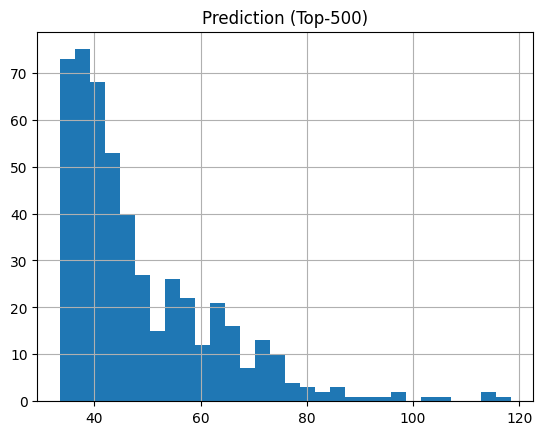

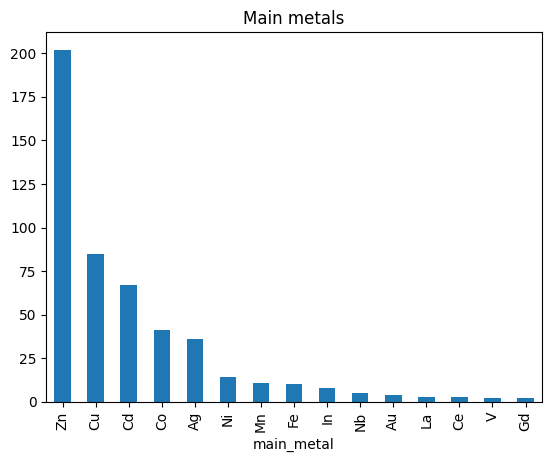

              prediction  density  volume  n_atoms  metal_frac  organic_frac
prediction         1.000   -0.076   0.283    0.206       0.076        -0.075
density           -0.076    1.000  -0.241   -0.172       0.302        -0.262
volume             0.283   -0.241   1.000    0.868      -0.014        -0.003
n_atoms            0.206   -0.172   0.868    1.000      -0.185         0.138
metal_frac         0.076    0.302  -0.014   -0.185       1.000        -0.895
organic_frac      -0.075   -0.262  -0.003    0.138      -0.895         1.000


In [36]:
import matplotlib.pyplot as plt

plt.figure(); df["prediction"].hist(bins=30); plt.title("Prediction (Top-500)"); plt.show()
plt.figure(); df["main_metal"].value_counts().head(15).plot(kind="bar"); plt.title("Main metals"); plt.show()

# 相关性热力图（只看几列核心特征）
cols = ["prediction","density","volume","n_atoms","metal_frac","organic_frac"]
corr = df[cols].corr()
print(corr.round(3))

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 标准化 embedding 并建 kNN
Xz = StandardScaler().fit_transform(X)
knn = NearestNeighbors(n_neighbors=11, metric="cosine").fit(Xz)
dists, idxs = knn.kneighbors(Xz)  # 包含自身

# 近邻平均距离（排除自身），作为“稀有度/不确定性”代理
local_dist = dists[:,1:].mean(axis=1)
df["knn_mean_dist"] = local_dist

# 归一化并计算综合分
from scipy.stats import zscore
alpha = 0.8   # 惩罚权重，可小步调试 0.5~1.0
df["score"] = df["prediction"] - alpha*zscore(df["knn_mean_dist"])

top50 = (df.sort_values("score", ascending=False)
           .head(50)
           .loc[:, ["id","prediction","knn_mean_dist","score","main_metal","density"]])

top50.to_csv("analysis_top500/shortlist_top50_ucb.csv", index=False)
top50.head(10)

,id,prediction,knn_mean_dist,score,main_metal,density
0,2019[Cu][nan]2[FSR]4,118.395859,0.259997,117.888614,Cu,0.783569
1,2007[Cu][dia]3[FSR]1,114.262589,0.314721,113.399630,Cu,0.599530
2,2009[La][pcu]3[FSR]1,113.816956,0.365849,112.621650,La,0.978203
3,2008[Cu][dia]3[FSR]2,105.825607,0.322873,104.909657,Cu,0.782219
4,2020[GeCu][sql]2[FSR]3,102.862885,0.151450,103.061222,Cu,1.360105
6,2020[GeCu][sql]2[FSR]2,97.328857,0.135470,97.631072,Cu,1.531878
5,2004[Ag][pts]3[FSR]1,97.572105,0.337479,96.561214,Ag,0.736524
7,2010[Co][tbo]3[FSR]1,94.155960,0.102994,94.669280,Co,0.461519
8,2004[Ag][pts]3[FSR]3,91.826561,0.336260,90.823587,Ag,0.709133
9,2004[Ag][pts]3[FSR]2,88.613785,0.133360,88.929715,Ag,0.733022


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

feat_cols = ["density","volume","n_atoms","metal_frac","organic_frac"]
Xtab = df[feat_cols].fillna(df[feat_cols].median())
y = df["prediction"].values

rf = RandomForestRegressor(n_estimators=400, random_state=42)
scores = cross_val_score(rf, Xtab, y, cv=5, scoring="r2")
rf.fit(Xtab, y)
importances = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)

print("CV R2 (tabular features -> prediction):", scores.mean().round(3))
importances

CV R2 (tabular features -> prediction): -47.372


volume          0.343243
density         0.280074
n_atoms         0.142895
organic_frac    0.120884
metal_frac      0.112904
dtype: float64

In [39]:
from sklearn.cluster import KMeans

k = 12
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Xz)
df["cluster"] = lab

# 每簇前3
reps = (df.sort_values("prediction", ascending=False)
          .groupby("cluster").head(3)
          .sort_values(["cluster","prediction"], ascending=[True,False]))
reps.to_csv("analysis_top500/cluster_reps_12x3.csv", index=False)

# 给每个代表找3个最近邻
rep_idx = df.index[df["id"].isin(reps["id"])]
nbr_dist, nbr_idx = knn.kneighbors(Xz[rep_idx], n_neighbors=4)  # 自身+3邻
bundle = []
for i, ridx in enumerate(rep_idx):
    for j in range(1,4):
        bundle.append({
            "rep_id": df.loc[ridx,"id"],
            "rep_pred": df.loc[ridx,"prediction"],
            "nn_id": df.iloc[nbr_idx[i,j]]["id"],
            "nn_pred": df.iloc[nbr_idx[i,j]]["prediction"],
            "dist": nbr_dist[i,j],
            "cluster": df.loc[ridx,"cluster"]
        })
pd.DataFrame(bundle).to_csv("analysis_top500/rep_triplets.csv", index=False)

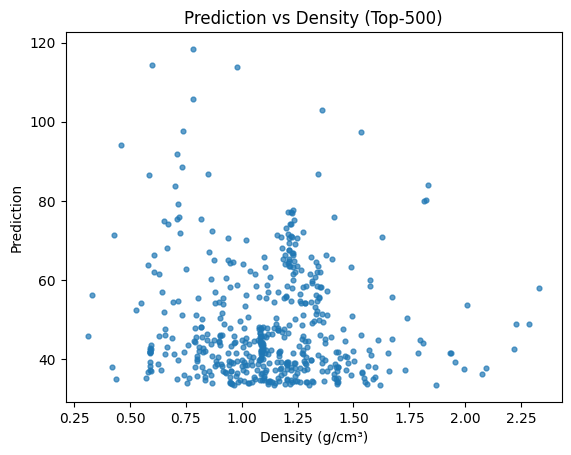

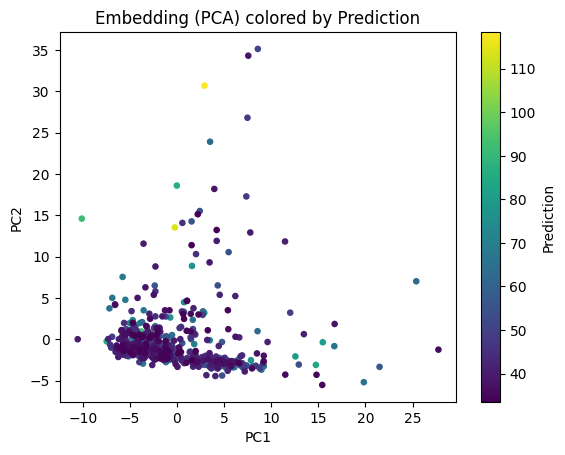

In [40]:
import matplotlib.pyplot as plt

# (a) 预测 vs 密度
plt.figure()
plt.scatter(df["density"], df["prediction"], s=12, alpha=0.7)
plt.xlabel("Density (g/cm³)"); plt.ylabel("Prediction")
plt.title("Prediction vs Density (Top-500)")
plt.show()

# (b) 嵌入空间的 PCA/UMAP 可替换，这里快速用 PCA
from sklearn.decomposition import PCA
pc = PCA(n_components=2, random_state=42).fit_transform(Xz)
plt.figure()
plt.scatter(pc[:,0], pc[:,1], c=df["prediction"], s=14)
plt.colorbar(label="Prediction")
plt.title("Embedding (PCA) colored by Prediction")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [41]:
# file: merge_coreid_into_last_layer.py
from pathlib import Path
import pandas as pd

# ===== Paths (edit if needed) =====
CR_PATH   = Path("data_core/cif/CSD-modified/CR_data_CSD_modified_20250227.csv")
FEAT_PATH = Path("analysis_top500/last_layer_features.csv")
OUT_PATH  = Path("analysis_top500/last_layer_features_merged.csv")

# ===== Load =====
cr   = pd.read_csv(CR_PATH)
feat = pd.read_csv(FEAT_PATH)

# ===== Validate required columns =====
required_cr_cols = {"coreid", "LCD (Å)", "PLD (Å)", "ASA (m2/cm3)", "VF", "ASA (m2/g)"}
missing = [c for c in required_cr_cols if c not in cr.columns]
if missing:
    raise KeyError(f"CR 文件缺少列: {missing}. 现有列: {cr.columns.tolist()}")

if "id" not in feat.columns:
    raise KeyError(f"最后一层特征文件缺少列: 'id'. 现有列: {feat.columns.tolist()}")

# ===== Normalize ID text (避免空格/类型差异) =====
feat["id"] = feat["id"].astype(str).str.strip()
cr["coreid"] = cr["coreid"].astype(str).str.strip()

# ===== Rename CR columns to standard names =====
rename_map = {
    "LCD (Å)": "lcd",
    "PLD (Å)": "pld",
    "ASA (m2/cm3)": "surface_area",
    "VF": "void_fraction",
    "ASA (m2/g)": "ASA"
}
cr_sub = cr[["coreid"] + list(rename_map.keys())].rename(columns=rename_map)

# 为什么去重：同一 coreid 多行会引入重复匹配，这里保留第一行，避免重复扩张
cr_sub = cr_sub.drop_duplicates(subset=["coreid"], keep="first")

# ===== Merge on id (left) vs coreid (right) =====
merged = feat.merge(cr_sub, left_on="id", right_on="coreid", how="left")

# 清理右键副本（保持左表原始 id）
merged = merged.drop(columns=["coreid"])

# ===== Save =====
merged.to_csv(OUT_PATH, index=False)

# ===== Report =====
added_cols = [c for c in ["void_fraction", "surface_area", "lcd", "pld", "ASA"] if c in merged.columns]
print({
    "rows_feat": len(feat),
    "rows_cr": len(cr),
    "rows_merged": len(merged),
    "added_columns": added_cols,
    "output": str(OUT_PATH),
    "unmatched_left_ids": int(merged["void_fraction"].isna().sum())  # 简单衡量未匹配数
})


{'rows_feat': 500, 'rows_cr': 9835, 'rows_merged': 500, 'added_columns': ['void_fraction', 'surface_area', 'lcd', 'pld', 'ASA'], 'output': 'analysis_top500\\last_layer_features_merged.csv', 'unmatched_left_ids': 0}


In [42]:
top500_path = Path("analysis_top500/last_layer_features_merged.csv")
pred_path = Path("data_core/core_predictions.csv")
out_path = top500_path  # 就地更新

# Load
df = pd.read_csv(top500_path)
pred = pd.read_csv(pred_path)

# Normalize column names
df.columns = df.columns.str.strip()
pred.columns = pred.columns.str.strip()

# Detect key
key = "id" if "id" in df.columns else next((c for c in df.columns if "id" in c.lower()), None)
if key is None:
    raise ValueError("merged_features_top500.csv 中未找到 ID 列。")

# Detect prediction column in pred
pred_key = key if key in pred.columns else next((c for c in pred.columns if c.lower() == key.lower()), None)
if pred_key is None:
    # fallback: any id-like col
    pred_key = next((c for c in pred.columns if any(x in c.lower() for x in ["id","material","structure"])), None)
if pred_key is None:
    raise ValueError("core_predictions.csv 中未找到用于匹配的 ID 列。")

pred_col_candidates = ["prediction", "pred", "y_pred", "yhat", "y_hat", "target_pred"]
pred_col = next((c for c in pred_col_candidates if c in pred.columns), None)
if pred_col is None:
    if pred.shape[1] == 2 and pred_key in pred.columns:
        pred_col = [c for c in pred.columns if c != pred_key][0]
    else:
        non_key_numeric = [c for c in pred.select_dtypes(include="number").columns if c != pred_key]
        if non_key_numeric:
            pred_col = non_key_numeric[0]
        else:
            raise ValueError("未找到预测值列（如 prediction/pred/y_pred 等），且无可用数值列。")

# Build slim pred df with standardized names
pred_slim = pred[[pred_key, pred_col]].rename(columns={pred_key: key, pred_col: "prediction"})

# Left-join to keep exactly 500 rows; overwrite existing prediction if present
df_no_pred = df.drop(columns=["prediction"], errors="ignore")
merged = df_no_pred.merge(pred_slim, on=key, how="left")

# Save in-place
merged.to_csv(out_path, index=False)

print(f"完成：已读取 {top500_path.name} 并基于 '{key}' 添加/覆盖 prediction 列。")
print(f"行数: {len(merged)}, 列数: {len(merged.columns)}")
print("前5行预览：")
display_cols = [key, "prediction"] + [c for c in merged.columns if c not in [key, "prediction"]][:5]
merged.head(5)[display_cols]

完成：已读取 last_layer_features_merged.csv 并基于 'id' 添加/覆盖 prediction 列。
行数: 500, 列数: 135
前5行预览：


,id,prediction,0,1,2,3,4
0,1997[Ag][nan]3[FSR]1,35.607574,0.004444,2.704913,2.425461,3.535447,0.000092
1,1997[Cu][dia]3[FSR]1,45.003746,0.000025,1.682958,0.000357,1.206400,0.000743
2,1998[Ni][pcu]3[FSR]1,38.521034,0.008143,1.961175,1.108122,2.404035,0.000626
3,2000[Ag][bpv]3[FSR]1,48.023796,0.000002,4.908135,0.002241,6.052838,0.000091
4,2000[Mn][lvt]2[FSR]1,38.373741,0.000010,3.326764,0.011880,2.250170,0.000739


In [43]:
from pathlib import Path
from typing import Tuple, Optional, List
import re

def extract_cell_lengths(cif_text: str) -> Tuple[float, float, float]:
    """Parse a,b,c; 返回 NaN 表示缺失（why: CIF 可能不含该键）。"""
    def _grab(key: str) -> float:
        # 更稳健的浮点匹配，容忍科学计数、前后空白、大小写
        m = re.search(
            rf"(?im)^\s*{re.escape(key)}\s+([+\-]?\d+(?:\.\d+)?(?:[eE][+\-]?\d+)?)\b",
            cif_text,
        )
        return float(m.group(1)) if m else np.nan

    a = _grab("_cell_length_a")
    b = _grab("_cell_length_b")
    c = _grab("_cell_length_c")
    return a, b, c


def parse_cif_for_id(cif_dir: Path, mid: str) -> Tuple[float, float, float]:
    """读取 <id>.cif；若不存在，返回 NaN。"""
    cif_path = cif_dir / f"{mid}.cif"
    if not cif_path.exists():
        return np.nan, np.nan, np.nan
    try:
        text = cif_path.read_text(encoding="utf-8", errors="ignore")
    except UnicodeDecodeError:
        text = cif_path.read_text(encoding="latin-1", errors="ignore")
    return extract_cell_lengths(text)


def zeta_sum(seq: List[float], s: int) -> float:
    """与用户代码一致的 ζ 变量计算。"""
    arr = np.asarray(seq, dtype=float)
    mask = np.isfinite(arr)
    if not mask.any():
        return np.nan
    arr = np.abs(arr[mask]) + 1e-6
    return float(np.sum(1.0 / (arr ** s)))


def main(
    merged_csv: Path = Path("analysis_top500/last_layer_features_merged.csv"),
    cif_dir: Path = Path("data_core/CIF_DIR_top500/cif"),
    out_csv: Path = Path("analysis_top500/last_layer_features_merged.csv"),
) -> None:
    if not merged_csv.exists():
        raise FileNotFoundError(f"missing: {merged_csv}")
    if not cif_dir.exists():
        raise FileNotFoundError(f"missing: {cif_dir}")

    df = pd.read_csv(merged_csv)
    # 关键列检查（why: 计算 ζ 依赖这些字段）
    needed = ["id", "void_fraction", "surface_area", "lcd", "pld"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"缺少必要列: {missing} in {merged_csv}")

    # 提取 a,b,c
    ids = df["id"].astype(str).tolist()
    abcs = [parse_cif_for_id(cif_dir, mid) for mid in ids]
    a_vals, b_vals, c_vals = zip(*abcs)
    df["a"] = a_vals
    df["b"] = b_vals
    df["c"] = c_vals

    # 计算 ζ 特征
    def _row_zeta(r, s: int) -> float:
        seq = [
            r.get("a"),
            r.get("b"),
            r.get("c"),
            r.get("void_fraction"),
            r.get("surface_area"),
            r.get("lcd"),
            r.get("pld"),
        ]
        return zeta_sum(seq, s)

    df["zeta_struct_s2"] = df.apply(lambda r: _row_zeta(r, 2), axis=1)
    df["zeta_struct_s3"] = df.apply(lambda r: _row_zeta(r, 3), axis=1)
    df["zeta_struct_s4"] = df.apply(lambda r: _row_zeta(r, 4), axis=1)

    # 导出
    df.to_csv(out_csv, index=False)

    # 简短报告
    hit = int(np.isfinite(df[["a", "b", "c"]].values).all(axis=1).sum())
    print(f"[OK] saved -> {out_csv}")
    print(f"a/b/c 完整解析条目: {hit}/{len(df)}")
    print(df[["id", "a", "b", "c", "zeta_struct_s2", "zeta_struct_s3", "zeta_struct_s4"]].head(5))


if __name__ == "__main__":
    # 可根据需要修改默认路径
    main()

[OK] saved -> analysis_top500\last_layer_features_merged.csv
a/b/c 完整解析条目: 500/500
                     id        a        b        c  zeta_struct_s2  \
0  1997[Ag][nan]3[FSR]1  24.4062  19.9709  15.8047    3.332864e+00   
1  1997[Cu][dia]3[FSR]1  16.8918  16.8918  16.8918    1.000000e+12   
2  1998[Ni][pcu]3[FSR]1  15.1045  15.1045  15.1045    3.616949e+00   
3  2000[Ag][bpv]3[FSR]1  16.9810  15.1658  24.4769    2.635742e+00   
4  2000[Mn][lvt]2[FSR]1  29.8909  29.8909  29.8909    2.689392e+00   

   zeta_struct_s3  zeta_struct_s4  
0    5.826500e+00    1.043846e+01  
1    1.000000e+18    1.000000e+24  
2    6.609620e+00    1.235774e+01  
3    4.036770e+00    6.378931e+00  
4    4.298999e+00    6.973719e+00  


In [44]:
# scripts/compute_stable_zeta.py
from __future__ import annotations
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd


# ---------- 归一化与ζ稳定计算 ----------
def robust_normalize(s: pd.Series) -> Tuple[pd.Series, Dict[str, float]]:
    """
    以 median/IQR 归一化，IQR=0 时回退 std，再不行用 1.0。
    why: 降低异常值影响，消除单位量纲差异。
    """
    s = pd.to_numeric(s, errors="coerce")
    med = float(np.nanmedian(s.values))
    q75 = float(np.nanpercentile(s.values, 75))
    q25 = float(np.nanpercentile(s.values, 25))
    iqr = q75 - q25
    scale = iqr if iqr > 0 else float(np.nanstd(s.values))
    if not np.isfinite(scale) or scale == 0.0:
        scale = 1.0
    out = (s - med) / scale
    return out, {"median": med, "iqr": iqr, "scale_used": scale}


def zeta_sum_stable(seq: Iterable[float], s: int, *, floor: float = 1e-2, offset: float = 0.1) -> float:
    """
    稳定ζ：对输入做 |x|+offset，并设地板 floor，避免 0 点奇异与极小值爆炸。
    why: 与原公式保持形态，但数值更稳健。
    """
    arr = np.asarray(list(seq), dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return float("nan")
    v = np.abs(arr) + offset
    v = np.maximum(v, floor)
    return float(np.sum(1.0 / (v ** s)))


def add_stable_zeta_columns(
    df: pd.DataFrame,
    cols: List[str] = None,
    s_list: Iterable[int] = (2, 3, 4),
    *,
    floor: float = 1e-2,
    offset: float = 0.1,
    prefix: str = "zeta_stable_s",
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, float]]]:
    """
    在 df 上新增稳定版ζ列，返回(含新列的df, 归一化统计)。
    """
    if cols is None:
        cols = ["a", "b", "c", "void_fraction", "surface_area", "lcd", "pld"]

    # 列检查
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"缺少必要列: {missing}")

    # 列级归一化
    norm_stats: Dict[str, Dict[str, float]] = {}
    norm = pd.DataFrame(index=df.index)
    for c in cols:
        norm[c], st = robust_normalize(df[c])
        norm_stats[c] = st

    # 行级 ζ 计算
    def _row(seq_vals: np.ndarray, s: int) -> float:
        return zeta_sum_stable(seq_vals, s, floor=floor, offset=offset)

    for s in s_list:
        df[f"{prefix}{s}"] = norm[cols].apply(lambda r: _row(r.values, s), axis=1)

    return df, norm_stats


# ---------- 示例：读取→计算→导出 ----------
# 输入/输出路径按需修改
in_path = Path("analysis_top500/last_layer_features_merged.csv")
out_path = Path("analysis_top500/last_layer_features_merged.csv")

df_in = pd.read_csv(in_path)
df_out, stats = add_stable_zeta_columns(
    df_in,
    cols=["a", "b", "c", "void_fraction", "surface_area", "lcd", "pld"],
    s_list=(2, 3, 4),
    floor=1e-2,     # 可调
    offset=0.1,     # 可调
    prefix="zeta_stable_s",
)
df_out.to_csv(out_path, index=False)

# 可选：快速查看统计与新列
print(f"[OK] saved -> {out_path}")
print("norm stats (per-column):", {k: {kk: round(vv, 6) for kk, vv in st.items()} for k, st in stats.items()})
print(df_out[["zeta_stable_s2", "zeta_stable_s3", "zeta_stable_s4"]].describe().round(6))


[OK] saved -> analysis_top500\last_layer_features_merged.csv
norm stats (per-column): {'a': {'median': 13.98115, 'iqr': 6.760825, 'scale_used': 6.760825}, 'b': {'median': 16.3734, 'iqr': 6.68865, 'scale_used': 6.68865}, 'c': {'median': 19.68985, 'iqr': 11.31245, 'scale_used': 11.31245}, 'void_fraction': {'median': 0.5963, 'iqr': 0.14705, 'scale_used': 0.14705}, 'surface_area': {'median': 1479.85, 'iqr': 1091.39875, 'scale_used': 1091.39875}, 'lcd': {'median': 6.288985, 'iqr': 3.321415, 'scale_used': 3.321415}, 'pld': {'median': 4.426535, 'iqr': 2.688225, 'scale_used': 2.688225}}
       zeta_stable_s2  zeta_stable_s3  zeta_stable_s4
count      500.000000      500.000000      500.000000
mean        69.855343      400.286006     2768.989164
std         49.917695      409.360699     3592.431670
min          3.340007        2.727623        2.471045
25%         30.384191       82.018582      272.423210
50%         58.874904      289.468803     1420.729321
75%         97.311410      570.96143

In [45]:
# I/O
in_csv = Path("analysis_top500/last_layer_features_merged.csv")
out_csv = Path("merged_features_top500_with_zeta_renamed.csv")

# Read
df = pd.read_csv(in_csv)

# Build rename map for numeric-named columns in [0,127]
rename_map = {}
for col in df.columns:
    # why: 有些解析器会把列名读成 int，这里统一转 int 尝试
    try:
        n = int(str(col))
    except ValueError:
        continue
    if 0 <= n <= 127:
        new_name = f"feature_{n}"
        rename_map[col] = new_name

# Detect potential name collisions (why: 防止已存在同名列导致覆盖)
collisions = [new for old, new in rename_map.items() if new in df.columns and new != old]
if collisions:
    raise ValueError(f"将产生列名冲突：{collisions}。请先处理这些同名列后再重命名。")

# Rename
df = df.rename(columns=rename_map)


# Save
df.to_csv(out_csv, index=False)

# Report
print(f"number of renamed columns：{len(rename_map)}")
print("example：", list(rename_map.items())[:10])
print(f"saved to：{out_csv}")
pd.read_csv("merged_features_top500_with_zeta_renamed.csv").rename(columns={"id":"material_id"}).to_csv("merged_features_top500_with_zeta_renamed.csv", index=False)



number of renamed columns：128
example： [('0', 'feature_0'), ('1', 'feature_1'), ('2', 'feature_2'), ('3', 'feature_3'), ('4', 'feature_4'), ('5', 'feature_5'), ('6', 'feature_6'), ('7', 'feature_7'), ('8', 'feature_8'), ('9', 'feature_9')]
saved to：merged_features_top500_with_zeta_renamed.csv


In [46]:
ref_path = Path("features_with_ids_new_with_zeta.csv")            # 基准列顺序
src_path = Path("merged_features_top500_with_zeta_renamed.csv")   # 待对齐
out_path = Path("merged_features_top500_with_zeta_aligned.csv")   # 输出

# 读取
df_ref = pd.read_csv(ref_path)      # 用于拿列顺序
df_src = pd.read_csv(src_path)      # 需要被重排的

# 统一去空白
df_ref.columns = df_ref.columns.str.strip()
df_src.columns = df_src.columns.str.strip()

ref_order = list(df_ref.columns)

# 列集合分析
missing = [c for c in ref_order if c not in df_src.columns]         # 基准里有、待对齐缺
common  = [c for c in ref_order if c in df_src.columns]             # 交集按基准顺序
extra   = [c for c in df_src.columns if c not in ref_order]         # 待对齐多出的列

# 重排：公共列按基准顺序 + 额外列置末尾（保留数据、避免丢列）
df_aligned = pd.concat([df_src[common], df_src[extra]], axis=1)

# 保存
df_aligned.to_csv(out_path, index=False)

# 摘要
print(f"[OK] Aligned and exported according to the baseline sequence.: {out_path}")
print(f"- Public Column: {len(common)}")
print(f"- missing columns: {len(missing)} -> {missing[:10]}{' ...' if len(missing)>10 else ''}")
print(f"- extra columns: {len(extra)} -> {extra[:10]}{' ...' if len(extra)>10 else ''}")


[OK] Aligned and exported according to the baseline sequence.: merged_features_top500_with_zeta_aligned.csv
- Public Column: 144
- missing columns: 2 -> ['actual', 'label_77K_100bar']
- extra columns: 0 -> []


In [47]:
from pandas.api.types import is_object_dtype
from catboost import CatBoost, Pool
from pathlib import Path

# === 路径 ===
data_path = Path("merged_features_top500_with_zeta_aligned.csv")
model_path = Path("catboost_model.cbm") # if Path("catboost_model.cbm").exists() else Path("catboost_model.json")
out_path = Path("analysis_top500/merged_features_top500_with_zeta_aligned_with_pred.csv")

# === 读取数据 ===
df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()

# === 加载模型 ===
model = CatBoost()
model.load_model(str(model_path))

# === 训练时特征顺序 ===
feature_names = list(model.feature_names_)
if not feature_names:
    raise RuntimeError("模型中未保存训练时的特征名，无法安全按列名对齐。")

# === 列名对齐（严格按训练顺序；忽略多余列） ===
missing = [c for c in feature_names if c not in df.columns]
if missing:
    raise ValueError(f"新数据缺少训练用列：{missing[:12]}{' ...' if len(missing)>12 else ''}")
X = df[feature_names].copy()
print(X.head(5))


# === 识别类别特征索引（无弃用警告的写法） ===
cat_idx = [
    i for i, c in enumerate(X.columns)
    if is_object_dtype(X[c]) or isinstance(X[c].dtype, pd.CategoricalDtype)
]

# === 预测 ===
pool = Pool(X, cat_features=cat_idx if cat_idx else None)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_pred = model.predict(X)

# === 追加列并导出 ===
df["catboost_prediction"] = y_pred
df.to_csv(out_path, index=False)
print(f"[OK] prediction complete 'catboost_prediction' -> {out_path}")


   feature_0  feature_1  feature_2  feature_3  feature_4     feature_5  \
0   0.004444   2.704913   2.425461   3.535447   0.000092  7.071347e-05   
1   0.000025   1.682958   0.000357   1.206400   0.000743  2.125494e-06   
2   0.008143   1.961175   1.108122   2.404035   0.000626  1.286529e-05   
3   0.000002   4.908135   0.002241   6.052838   0.000091  7.761702e-08   
4   0.000010   3.326764   0.011880   2.250170   0.000739  5.128922e-06   

   feature_6  feature_7  feature_8  feature_9  ...        b        c  \
0   7.301160   0.028908   4.182375   0.254372  ...  19.9709  15.8047   
1   8.052744   0.000537   3.953945   0.000004  ...  16.8918  16.8918   
2   6.918149   0.248404   3.016480   0.122176  ...  15.1045  15.1045   
3   9.494260   0.000959   7.024593   0.000006  ...  15.1658  24.4769   
4   7.212248   0.000068   2.216215   0.000155  ...  29.8909  29.8909   

   void_fraction  surface_area       lcd      pld      ASA  zeta_stable_s2  \
0         0.5564       1255.48   4.80081  4.

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

# 输入文件（含 prediction 与 catboost_prediction）
path = "analysis_top500/merged_features_top500_with_zeta_aligned_with_pred.csv"

df = pd.read_csv(path)
need = ["prediction", "catboost_prediction"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"缺少列: {missing}")

# 数值化并对齐非缺失
y_true = pd.to_numeric(df["prediction"], errors="coerce")
y_pred = pd.to_numeric(df["catboost_prediction"], errors="coerce")
mask = y_true.notna() & y_pred.notna()
y_true = y_true[mask].values
y_pred = y_pred[mask].values

if y_true.size == 0:
    raise ValueError("有效对比样本为 0；请检查是否全为缺失/非数值。")

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Samples used: {y_true.size}")
print(f"MSE: {mse:.6f}")
print(f"R2 : {r2:.6f}")


Samples used: 500
MSE: 903.356326
R2 : -3.407787


In [49]:
from catboost import CatBoost, Pool


df = pd.read_csv("analysis_top500/merged_features_top500_with_zeta_aligned_with_pred.csv")
df.columns = df.columns.str.strip()

# === 加载模型 ===
model = CatBoost()
model_catboost_path = "catboost_model_2.cbm"
model.load_model(str(model_catboost_path))

# === 训练时特征顺序 ===
feature_names = list(model.feature_names_)
if not feature_names:
    raise RuntimeError("模型中未保存训练时的特征名，无法安全按列名对齐。")

# === 列名对齐（严格按训练顺序；忽略多余列） ===
missing = [c for c in feature_names if c not in df.columns]
if missing:
    raise ValueError(f"新数据缺少训练用列：{missing[:12]}{' ...' if len(missing)>12 else ''}")
X = df[feature_names].copy()
print(X.head(5))


# === 识别类别特征索引（无弃用警告的写法） ===
cat_idx = [
    i for i, c in enumerate(X.columns)
    if is_object_dtype(X[c]) or isinstance(X[c].dtype, pd.CategoricalDtype)
]

# === 预测 ===
pool = Pool(X, cat_features=cat_idx if cat_idx else None)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_pred = model.predict(X)

# === 追加列并导出 ===
df["catboost_prediction_2"] = y_pred
df.to_csv(out_path, index=False)
print(f"[OK] prediction complete 'catboost_prediction_2' -> {out_path}")



         a        b        c  void_fraction  surface_area       lcd      pld  \
0  24.4062  19.9709  15.8047         0.5564       1255.48   4.80081  4.42267   
1  16.8918  16.8918  16.8918         0.4396          0.00   5.07553  2.80989   
2  15.1045  15.1045  15.1045         0.5334       1311.05   5.68922  4.14617   
3  16.9810  15.1658  24.4769         0.6294       1722.79   6.49823  3.57483   
4  29.8909  29.8909  29.8909         0.6154       1602.71  12.26015  5.07041   

       ASA  
0  1187.66  
1     0.00  
2  1291.34  
3  1484.26  
4  1757.29  
[OK] prediction complete 'catboost_prediction_2' -> analysis_top500\merged_features_top500_with_zeta_aligned_with_pred.csv


In [50]:
# # file: train_gpr_rq_fixed.py
# from __future__ import annotations
# from pathlib import Path
# import json
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel
# import joblib
# 
# # ===== Paths =====
# DATA_PATH = Path("features_with_ids_new_with_zeta.csv")  
# OUT_DIR   = Path("./gpr_rq_out"); OUT_DIR.mkdir(parents=True, exist_ok=True)
# 
# # ===== Load =====
# df = pd.read_csv(DATA_PATH)
# if "actual" not in df.columns:
#     raise KeyError("未找到标签列 'actual'。")
# 
# # ===== [MOD] 固定随机子样本 1800 条（可复现） =====
# if len(df) < 1800:
#     raise ValueError(f"样本数不足 1800，当前 n={len(df)}")
# df = df.sample(n=1800, random_state=42).reset_index(drop=True)  # [MOD]
# 
# 
# # ID（可选）
# id_col = next((c for c in df.columns if c.lower() in ["id","coreid","refcode","material_id"]), None)
# 
# # ===== Features =====
# base_feats = ["a","b","c","void_fraction","surface_area","lcd","pld",
#               "zeta_stable_s2","zeta_stable_s3","zeta_stable_s4"]
# extra_feats = [f"feature_{i}" for i in range(128) if f"feature_{i}" in df.columns]
# features = [c for c in base_feats if c in df.columns] + extra_feats
# if not features:
#     raise ValueError("未找到任何特征列。")
# X = df[features].copy()
# y = df["actual"].astype(float).values
# 
# # ===== Preprocess =====
# pre = Pipeline([
#     ("imp", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler()),
# ])
# 
# Xp = pre.fit_transform(X)  # 仅用于得到形状与稳定训练
# 
# # ===== Kernel (RQ with scalar length_scale) =====
# # RationalQuadratic(length_scale=1.0) 必须是标量，不能传 np.ones(d)
# kernel = (
#     ConstantKernel(1.0, (1e-3, 1e3))
#     * RationalQuadratic(length_scale=1.0, alpha=1.0,
#                         length_scale_bounds=(1e-3, 1e3),
#                         alpha_bounds=(1e-3, 1e3))
#     + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e0))
# )
# 
# gpr = GaussianProcessRegressor(
#     kernel=kernel,
#     alpha=0.0,           
#     normalize_y=True,
#     random_state=42,
#     n_restarts_optimizer=3
# )
# 
# # ===== Split =====
# Xtr, Xte, ytr, yte = train_test_split(Xp, y, test_size=0.2, random_state=42)
# 
# # ===== Lightweight search over scalar params =====
# param_dist = {
#     "kernel__k1__k2__length_scale": np.logspace(-1, 2, 10),  # 标量
#     "kernel__k1__k2__alpha":       np.logspace(-2, 2, 10),   # 标量
#     "kernel__k2__noise_level":     np.logspace(-4, -1, 6),   # 标量
# }
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# search = RandomizedSearchCV(
#     gpr, param_distributions=param_dist, n_iter=20,
#     cv=cv, scoring="neg_mean_absolute_error", random_state=42, n_jobs=-1,
#     error_score="raise"
# )
# search.fit(Xtr, ytr)
# best = search.best_estimator_
# 
# # ===== Eval =====
# def metrics(y_true, y_pred):
#     return {
#         "MAE": float(mean_absolute_error(y_true, y_pred)),
#         "RMSE": float(mean_squared_error(y_true, y_pred, squared=False)),
#         "R2": float(r2_score(y_true, y_pred)),
#     }
# 
# ytr_hat = best.predict(Xtr)
# yte_hat = best.predict(Xte)
# report = {
#     "best_params": search.best_params_,
#     "train": metrics(ytr, ytr_hat),
#     "test":  metrics(yte, yte_hat),
#     "n_samples": int(len(df)),
#     "n_features": int(Xp.shape[1]),
#     "features_used": features,
# }
# 
# # ===== Save =====
# joblib.dump(pre, OUT_DIR / "preprocess.joblib")
# joblib.dump(best, OUT_DIR / "gpr_rq_model.joblib")
# with open(OUT_DIR / "metrics.json", "w") as f:
#     json.dump(report, f, indent=2, ensure_ascii=False)
# 
# # 全量拟合
# best.fit(Xp, y)
# pred_full = best.predict(Xp)
# out_pred = pd.DataFrame({
#     **({"id": df[id_col].astype(str)} if id_col else {}),
#     "actual": y,
#     "y_pred_gpr_rq": pred_full
# })
# out_pred.to_csv(OUT_DIR / "predictions_full.csv", index=False)
# 
# print("OK | best_params:", search.best_params_)
# print("Train:", report["train"])
# print("Test:", report["test"])
# print("Saved to:", OUT_DIR)


# file: train_gpr_rq_fixed_subsample_with_progress.py
from __future__ import annotations
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.inspection import permutation_importance
from sklearn.base import clone  # [FIX]
import joblib

from tqdm.auto import tqdm
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [51]:
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

# ===== Paths =====
DATA_PATH = Path("features_with_ids_new_with_zeta.csv")  # 修改为你的路径
OUT_DIR   = Path("./gpr_rq_out"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===== Load =====
df = pd.read_csv(DATA_PATH)
if "actual" not in df.columns:
    raise KeyError("未找到标签列 'actual'。")

# ===== 固定随机子样本 1800 条 =====
if len(df) < 1800:
    raise ValueError(f"样本数不足 1800，当前 n={len(df)}")
df = df.sample(n=1800, random_state=42).reset_index(drop=True)

# ID（可选）
id_col = next((c for c in df.columns if c.lower() in ["id","coreid","refcode","material_id"]), None)

# ===== Features =====
base_feats = ["a","b","c","void_fraction","surface_area","lcd","pld",
              "zeta_stable_s2","zeta_stable_s3","zeta_stable_s4", "ASA"]
extra_feats = [f"feature_{i}" for i in range(128) if f"feature_{i}" in df.columns]
features = [c for c in base_feats if c in df.columns] + extra_feats
if not features:
    raise ValueError("未找到任何特征列。")

X_raw = df[features].copy()
print(X_raw.head(5))
print(X_raw["ASA"])

           a          b          c  void_fraction  surface_area    lcd    pld  \
0   6.817900  26.552285  19.551833       0.712658        1457.4  14.25  13.25   
1  13.033293  12.759400  13.032268       0.751142        2379.0   8.75   6.25   
2   6.817900  11.102288  16.418042       0.730331        1864.1   8.25   7.25   
3  14.809374  21.606444  21.606444       0.621769        1558.9  11.75  11.25   
4  19.805407  12.759400  19.805399       0.614081        2075.5   6.75   5.25   

   zeta_stable_s2  zeta_stable_s3  zeta_stable_s4  ...  feature_118  \
0       21.518589       51.158099      131.611943  ...     6.943674   
1       62.097476      220.163845      881.769987  ...    10.157580   
2       84.346520      375.884651     1859.175814  ...     7.071613   
3      103.401279      590.630151     3690.333624  ...     9.837584   
4       76.743394      304.280977     1299.118612  ...     9.123854   

   feature_119   feature_120  feature_121   feature_122  feature_123  \
0    10.558988

In [53]:

y = df["actual"].astype(float).values

# ===== Train/Test split (按索引) =====
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
Xtr_raw, Xte_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
ytr_raw, yte_raw = y[train_idx], y[test_idx]

# ===== Preprocess =====
pre = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
Xtr = pre.fit_transform(Xtr_raw)
Xte = pre.transform(Xte_raw)

# ===== GPR-RQ Kernel (scalar length_scale) =====
kernel = (
    ConstantKernel(1.0, (1e-3, 1e3))
    * RationalQuadratic(length_scale=1.0, alpha=1.0,
                        length_scale_bounds=(1e-3, 1e3),
                        alpha_bounds=(1e-3, 1e3))
    + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-6, 1e1))
)
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,
    normalize_y=True,
    random_state=42,
    n_restarts_optimizer=3
)

# ===== Randomized Search =====
param_dist = {
    "kernel__k1__k2__length_scale": np.logspace(-1, 2, 10),
    "kernel__k1__k2__alpha":       np.logspace(-2, 2, 10),
    "kernel__k2__noise_level":     np.logspace(-4, -1, 6),
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    gpr, param_distributions=param_dist, n_iter=20,
    cv=cv, scoring="neg_mean_absolute_error", random_state=42, n_jobs=-1,
    error_score="raise"
)
total_fits = search.n_iter * cv.get_n_splits()
with tqdm_joblib(tqdm(total=total_fits, desc="RandomizedSearchCV", unit="fit")):
    search.fit(Xtr, ytr_raw)
best = search.best_estimator_

RandomizedSearchCV:   0%|          | 0/100 [00:00<?, ?fit/s]

D:\pycharm\py_project\CGCNN2_data_science_project\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [54]:
# ===== Metrics =====
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))  # 兼容旧版 sklearn
    return {"MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": rmse,
            "R2": float(r2_score(y_true, y_pred))}

# ===== Eval =====
ytr_hat = best.predict(Xtr)
yte_hat = best.predict(Xte)
report = {
    "best_params": search.best_params_,
    "train": metrics(ytr_raw, ytr_hat),
    "test":  metrics(yte_raw, yte_hat),
    "n_samples_subsampled": int(len(df)),
    "n_features": int(Xtr.shape[1]),
    "features_used": features,
}

# ===== Save model & preprocess =====
joblib.dump(pre, OUT_DIR / "preprocess.joblib")
joblib.dump(best, OUT_DIR / "gpr_rq_model.joblib")
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

# ===== 全量(子样本)拟合并导出预测 =====
X_all = pre.fit_transform(X_raw)
best.fit(X_all, y)
pred_full = best.predict(X_all)
pd.DataFrame({
    **({"id": df[id_col].astype(str)} if id_col else {}),
    "actual": y,
    "y_pred_gpr_rq": pred_full
}).to_csv(OUT_DIR / "predictions_full.csv", index=False)

print(f"OK | subsampled n={len(df)}")
print("Best params:", search.best_params_)
print("Train:", report["train"])
print("Test:", report["test"])
print("Saved to:", OUT_DIR)

D:\pycharm\py_project\CGCNN2_data_science_project\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


OK | subsampled n=1800
Best params: {'kernel__k2__noise_level': np.float64(0.0001), 'kernel__k1__k2__length_scale': np.float64(100.0), 'kernel__k1__k2__alpha': np.float64(0.21544346900318834)}
Train: {'MAE': 0.5196273695563448, 'RMSE': 0.7207231303608349, 'R2': 0.9984219560150073}
Test: {'MAE': 0.7696450207053788, 'RMSE': 1.0735719669523185, 'R2': 0.9968965374157732}
Saved to: gpr_rq_out


D:\pycharm\py_project\CGCNN2_data_science_project\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


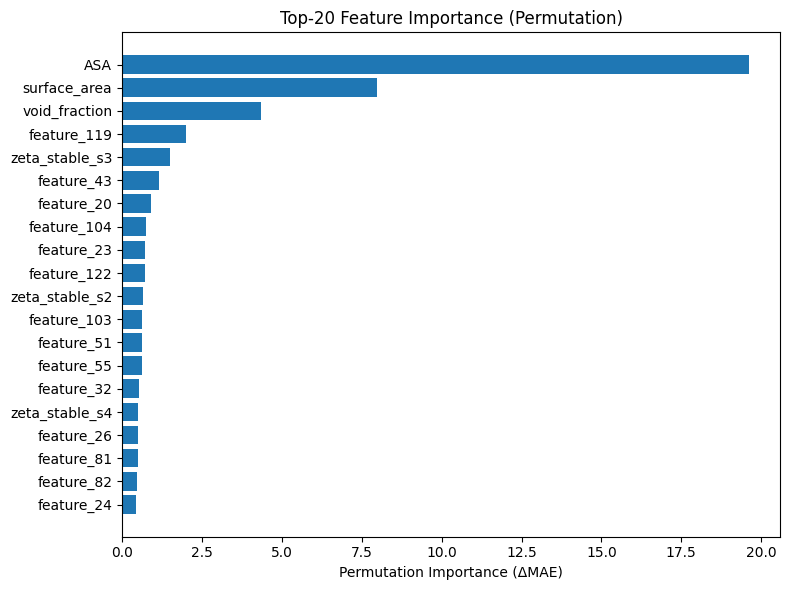

In [55]:
from sklearn.base import clone

# ===== 学习曲线 =====
# [FIX] 不要用 GaussianProcessRegressor(**best.get_params())；用 clone(best)
pipe_for_lc = Pipeline([("pre", clone(pre)), ("gpr", clone(best))])  # [FIX]
train_sizes = np.linspace(0.1, 1.0, 8)
ts, tr_scores, val_scores = learning_curve(
    pipe_for_lc, X_raw, y,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=train_sizes, scoring="neg_mean_absolute_error", n_jobs=-1
)
tr_mae = -tr_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)
plt.figure()
plt.plot(ts, tr_mae, marker="o", label="Train MAE")
plt.plot(ts, val_mae, marker="s", label="Val MAE")
plt.xlabel("Training examples"); plt.ylabel("MAE"); plt.title("Learning Curve (GPR-RQ)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(OUT_DIR / "learning_curve.png", dpi=150); plt.close()

# ===== 残差图 =====
def save_residual_plots(y_true, y_pred, split_name: str):
    res = y_true - y_pred
    plt.figure(); plt.scatter(y_true, res, alpha=0.6, s=14); plt.axhline(0)
    plt.xlabel("y_true"); plt.ylabel("Residual (y_true - y_pred)")
    plt.title(f"Residuals vs y_true ({split_name})"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"residuals_scatter_{split_name}.png", dpi=150); plt.close()
    plt.figure(); plt.hist(res, bins=30, alpha=0.9)
    plt.xlabel("Residual"); plt.ylabel("Count")
    plt.title(f"Residuals Histogram ({split_name})"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"residuals_hist_{split_name}.png", dpi=150); plt.close()

save_residual_plots(ytr_raw, ytr_hat, "train")
save_residual_plots(yte_raw, yte_hat, "test")

# ===== 特征敏感性（Permutation Importance on test set）=====
# [FIX] 同样使用 clone(pre) 与 clone(best)，在原始特征上评估
pipe = Pipeline([("pre", clone(pre)), ("gpr", clone(best))])  # [FIX]
pipe.fit(Xtr_raw, ytr_raw)
perm = permutation_importance(
    pipe, Xte_raw, yte_raw,
    n_repeats=10, random_state=42,
    scoring="neg_mean_absolute_error", n_jobs=-1
)
imp_df = pd.DataFrame({
    "feature": X_raw.columns,
    "importance_mae_decrease": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mae_decrease", ascending=False)
imp_df.to_csv(OUT_DIR / "feature_importance.csv", index=False)

topk = 20
top = imp_df.head(topk)
plt.figure(figsize=(8, 6))
plt.barh(top["feature"][::-1], top["importance_mae_decrease"][::-1])
plt.xlabel("Permutation Importance (ΔMAE)")
plt.title(f"Top-{topk} Feature Importance (Permutation)")
plt.tight_layout()
plt.savefig(OUT_DIR / "feature_importance_top20.png", dpi=150)
plt.show()

In [56]:
# ===== [APPEND ONLY] CatBoost =====
from catboost import CatBoostRegressor, Pool
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

OUT_DIR = Path("./gpr_rq_out")  
pred_csv_path = OUT_DIR / "predictions_full.csv"

# 需要以下变量已在上文存在：X_raw, y, train_idx, test_idx, id_col
Xtr_raw_cb, Xte_raw_cb = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
ytr_cb,      yte_cb    = y[train_idx],         y[test_idx]

# 1) 训练 CatBoost （数值特征，缺失自动处理）
cat_model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.06,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
train_pool = Pool(Xtr_raw_cb, ytr_cb)
valid_pool = Pool(Xte_raw_cb, yte_cb)
cat_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=False)

# 2) 评估 CatBoost（与 GPR 的切分一致）
ytr_hat_cat = cat_model.predict(Xtr_raw_cb)
yte_hat_cat = cat_model.predict(Xte_raw_cb)

def _report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    return {"MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": rmse,
            "R2": float(r2_score(y_true, y_pred))}

print("[CatBoost] Train:", _report(ytr_cb, ytr_hat_cat))
print("[CatBoost] Test :", _report(yte_cb, yte_hat_cat))

# 3) 在全量 1800 上预测，并追加到 predictions_full.csv
y_all_hat_cat = cat_model.predict(X_raw)
# 若 predictions_full.csv 尚不存在，则由上文已生成；这里读取并合并
pred_df = pd.read_csv(pred_csv_path)
# 对齐顺序：假设与 df 行顺序一致；若有 id 列则按 id 对齐更稳妥
if id_col and id_col in pred_df.columns:
    # 构造带 id 的 CatBoost 预测，再按 id 合并
    cb_full_df = pd.DataFrame({
        id_col: (X_raw.index.map(lambda i: str(df.iloc[i][id_col])) if id_col else np.arange(len(X_raw))).astype(str),
        "catboost_prediction": y_all_hat_cat
    })
    pred_df[id_col] = pred_df[id_col].astype(str)
    pred_df = pred_df.merge(cb_full_df, on=id_col, how="left")
else:
    pred_df["catboost_prediction"] = y_all_hat_cat

# 写回（覆盖）
pred_df.to_csv(pred_csv_path, index=False)
print(f"[CatBoost] 已将 catboost_prediction 写入: {pred_csv_path}")

# 4) —— 模型融合：在验证集上求最优加权 w，y_fused = w*y_gpr + (1-w)*y_cat ——
# 读取 GPR 预测（已在 predictions_full.csv 的 y_pred_gpr_rq 列）
gpr_all = pred_df["y_pred_gpr_rq"].values
# 从全量里切出与 test_idx 对应的验证集 GPR/CatBoost 预测
gpr_te = gpr_all[test_idx]
cat_te = yte_hat_cat  # 上面算好的
# 网格搜索 w∈[0,1]，以 MAE 最优
grid = np.linspace(0, 1, 101)
best_w, best_mae = None, float("inf")
for w in grid:
    y_fused = w * gpr_te + (1 - w) * cat_te
    mae = mean_absolute_error(yte_cb, y_fused)
    if mae < best_mae:
        best_mae, best_w = mae, w
print({"fusion_best_w": float(best_w), "fusion_val_MAE": float(best_mae)})

# 评估融合在验证集上的效果（同时给出 RMSE/R2）
def _report_all(y_true, y_gpr, y_cat, w):
    y_fused = w * y_gpr + (1 - w) * y_cat
    mse = mean_squared_error(y_true, y_fused)
    return {
        "MAE": float(mean_absolute_error(y_true, y_fused)),
        "RMSE": float(np.sqrt(mse)),
        "R2": float(r2_score(y_true, y_fused))
    }

print("[Fusion@test] vs y_true:",
      _report_all(yte_cb, gpr_te, cat_te, best_w))

# 5) 在全量 1800 上用最优 w 生成融合预测，并写回文件
y_all_fused = best_w * gpr_all + (1 - best_w) * y_all_hat_cat
pred_df["y_pred_fused"] = y_all_fused
pred_df.to_csv(pred_csv_path, index=False)
print(f"[Fusion] 已追加 y_pred_fused（w={best_w:.3f}）到: {pred_csv_path}")

# 6) （可选）把关键指标写个摘要 JSON 方便记录
summary = {
    "catboost_train": _report(ytr_cb, ytr_hat_cat),
    "catboost_test":  _report(yte_cb, yte_hat_cat),
    "fusion": {
        "best_w": float(best_w),
        "test_metrics": _report_all(yte_cb, gpr_te, cat_te, best_w)
    }
}
with open(OUT_DIR / "ensemble_summary.json", "w") as f:
    import json; json.dump(summary, f, indent=2)
print(f"[Done] 融合摘要写入: {OUT_DIR/'ensemble_summary.json'}")


[CatBoost] Train: {'MAE': 0.012155149541407922, 'RMSE': 0.01570495547625834, 'R2': 0.999999250700224}
[CatBoost] Test : {'MAE': 1.2221834142426038, 'RMSE': 1.75630965577262, 'R2': 0.9916941063429274}
[CatBoost] 已将 catboost_prediction 写入: gpr_rq_out\predictions_full.csv
{'fusion_best_w': 1.0, 'fusion_val_MAE': 0.5041526962408827}
[Fusion@test] vs y_true: {'MAE': 0.5041526962408827, 'RMSE': 0.686518156485679, 'R2': 0.998730922209994}
[Fusion] 已追加 y_pred_fused（w=1.000）到: gpr_rq_out\predictions_full.csv
[Done] 融合摘要写入: gpr_rq_out\ensemble_summary.json


In [57]:

from pathlib import Path
import json

cat_model_path = OUT_DIR / "catboost_model.cbm"
cat_model.save_model(str(cat_model_path))  


meta = {
    "features": list(X_raw.columns),
    "params": cat_model.get_all_params(),  
    "n_train": int(len(train_idx)),
    "n_test": int(len(test_idx)),
    "random_seed": 42,
}
with open(OUT_DIR / "catboost_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f"[Save] CatBoost model -> {cat_model_path}")
print(f"[Save] Meta -> {OUT_DIR / 'catboost_meta.json'}")

[Save] CatBoost model -> gpr_rq_out\catboost_model.cbm
[Save] Meta -> gpr_rq_out\catboost_meta.json


In [58]:
# file: run_fusion_on_top500.py
# Purpose: predict with trained GPR + CatBoost, fuse to fusion_prediction, compare against 'prediction'
from __future__ import annotations
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

# CatBoost import is required for loading the model
from catboost import CatBoostRegressor

# ------------------------ Paths ------------------------
IN_PATH  = Path("analysis_top500/merged_features_top500_with_zeta_aligned_with_pred.csv")
OUT_DIR  = Path("gpr_rq_out")                   # where models/summary were saved
OUT_PATH = IN_PATH.with_name(IN_PATH.stem + "_with_fusion.csv")

# ------------------------ Load data ------------------------
df = pd.read_csv(IN_PATH)
# Ensure the reference column exists
if "prediction" not in df.columns:
    raise KeyError("Input CSV must contain a 'prediction' column to compare with fusion_prediction.")

# ------------------------ Build feature list ------------------------
# Why: be robust to missing columns and only use those present.
core_feats = [
    "a", "b", "c",
    "void_fraction", "surface_area", "lcd", "pld",
    "zeta_stable_s2", "zeta_stable_s3", "zeta_stable_s4", "ASA"
]
# Two patterns: feature_0..feature_127 (requested) and fallback feature0..feature127 (if your file used that)
feat_block_underscore = [f"feature_{i}" for i in range(128) if f"feature_{i}" in df.columns]
feat_block_compact    = [f"feature{i}"   for i in range(128) if f"feature{i}"   in df.columns]
feature_cols = [c for c in core_feats if c in df.columns] + (feat_block_underscore or feat_block_compact)
if not feature_cols:
    raise ValueError("No input features found. Expected columns like feature_0..feature_127 plus a,b,c,...")

X = df[feature_cols].copy()

# ------------------------ Load GPR ------------------------
# Why: prefer a pipeline that includes preprocessing; fallback to (preprocess + gpr_model) assembled pipeline.
gpr_pipe = None
pipe_path      = OUT_DIR / "gpr_rq_pipeline_refit_all.joblib"
preprocess_ref = OUT_DIR / "preprocess_refit_all.joblib"
preprocess     = OUT_DIR / "preprocess.joblib"
gpr_refit_all  = OUT_DIR / "gpr_rq_model_refit_all.joblib"
gpr_model      = OUT_DIR / "gpr_rq_model.joblib"

if pipe_path.exists():
    # Best case: single pipeline that accepts raw features
    gpr_pipe = joblib.load(pipe_path)
else:
    # Assemble pipeline from saved parts
    if gpr_refit_all.exists():
        gpr = joblib.load(gpr_refit_all)
    elif gpr_model.exists():
        gpr = joblib.load(gpr_model)
    else:
        raise FileNotFoundError("Cannot find GPR model. Tried gpr_rq_model_refit_all.joblib and gpr_rq_model.joblib")

    if preprocess_ref.exists():
        pre = joblib.load(preprocess_ref)
    elif preprocess.exists():
        pre = joblib.load(preprocess)
    else:
        raise FileNotFoundError("Cannot find preprocess joblib. Tried preprocess_refit_all.joblib and preprocess.joblib")

    gpr_pipe = make_pipeline(pre, gpr)

# ------------------------ Load CatBoost ------------------------
cat_path = OUT_DIR / "catboost_model.cbm"
if not cat_path.exists():
    raise FileNotFoundError(f"Cannot find CatBoost model at: {cat_path}")
cat_model = CatBoostRegressor()
cat_model.load_model(str(cat_path))

# ------------------------ Get fusion weight ------------------------
best_w = 0.5  # default if no summary is available
summary_path = OUT_DIR / "ensemble_summary.json"
if summary_path.exists():
    try:
        with open(summary_path, "r", encoding="utf-8") as f:
            summ = json.load(f)
        # Why: robust access to nested keys
        if isinstance(summ, dict):
            maybe = summ.get("fusion", {}).get("best_w", None)
            if isinstance(maybe, (int, float)):
                best_w = float(maybe)
    except Exception:
        pass  # keep default 0.5

# ------------------------ Predict ------------------------
# Why: GPR pipeline handles impute/scale; CatBoost handles missing internally.
gpr_pred = gpr_pipe.predict(X).astype(float)
cat_pred = cat_model.predict(X).astype(float)

fusion_pred = best_w * gpr_pred + (1.0 - best_w) * cat_pred
df["fusion_prediction"] = fusion_pred

# ------------------------ Compare fusion vs 'prediction' ------------------------
y_ref = pd.to_numeric(df["prediction"], errors="coerce")
y_ref_2 = pd.to_numeric(df["catboost_prediction"], errors="coerce")

if y_ref.isna().any():
    # Why: guard against non-numeric reference values
    raise ValueError("Column 'prediction' contains non-numeric values; cannot compute metrics.")

def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

r2_1  = float(r2_score(y_ref.values, fusion_pred))
r2_2 = float(r2_score(y_ref_2.values, fusion_pred))
mae = float(mean_absolute_error(y_ref.values, fusion_pred))
rmse = _rmse(y_ref.values, fusion_pred)

# ------------------------ Save & Report ------------------------
df.to_csv(OUT_PATH, index=False)

print({
    "rows": int(len(df)),
    "features_used": feature_cols[:5] + (["..."] if len(feature_cols) > 5 else []),
    "fusion_weight_w": best_w,
    "output_csv": str(OUT_PATH),
    "metrics_vs_prediction": {"R2": r2_1, "MAE": mae, "RMSE": rmse},
    "catboost_vs_prediction": {"R2": r2_2}
})



{'rows': 500, 'features_used': ['a', 'b', 'c', 'void_fraction', 'surface_area', '...'], 'fusion_weight_w': 1.0, 'output_csv': 'analysis_top500\\merged_features_top500_with_zeta_aligned_with_pred_with_fusion.csv', 'metrics_vs_prediction': {'R2': -2.437594484338541, 'MAE': 23.62586631735027, 'RMSE': 26.54279095806489}, 'catboost_vs_prediction': {'R2': 0.5569193139174065}}


In [ ]:



# 使用训练好的融合模型，使用数据集merged_features_top500_with_zeta_aligned_with_pred.csv预测结果，添加预测结果列fusion_prediction在数据集中，变量与融合模型的输入变量一致， 输入变量为feature_0到feature_127, a b c void_fraction surface_area lcd pld zeta_stable_s2 zeta_stable_s3 zeta_stable_s4 用变量名作为索引，预测完之后，把fusion_prediction与prediction列作比较，输出两者之间的R2和MAE和RMSE。输出的代码的注释用英文，但是代码之外的解释性文字可以用中文
# 分析，那个数据集中的样本对于融合模型来说是全新的样本，那个数据集中的prediction来自于CGCNN模型的预测，结果发现融合模型的预测结果和CGCNN的结果高度# 一致，但是我之前使用了训练好的单独的catboost模型（基于和CGCNN和融合模型相同的数据源MOFXDB）在这个数据集上预测，发现预测结果和CGCNN结果偏差很大，两者之间的R2为负数，MSE数值很大。请给我解释可能的原因，并且给我得出一个可能的结论